<b>Импортируем библиотеки:</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns

<br/><a name="1."></a>
## Шаг 1. Ознакомление с данными
<font size="2">([к содержанию](#0.0))</font>

Загружаем данные:

In [2]:
games = pd.read_csv('games.csv')

In [3]:
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


В последних столбцах есть пропуски, узнаем о пропусках по всему датафрейму.<br/>
Посмотрим общую информацию о датафрейме:

<br/><a name="1.1."></a>
<b>1.1. Общая информация о датафрейме.</b><br/>
<font size="2">([к содержанию](#0.0))</font>

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Действительно, их очень много в столбцах Critic_Score,	User_Score,	Rating.

<br/><a name="1.2."></a>
<b>1.2. В каких столбцах меняем типы данных.</b><br/>
<font size="2">([к содержанию](#0.0))</font>
* <b>user_score</b> - сейчас у столбца тип <b>object</b> - поменяем на <b>'float'</b>.
<br/>
В остальных столбцах кажется всё в порядке.

<br/><a name="1.3."></a>
<b>1.3. Информация о пропусках, методы их заполнения.</b><br/>
<font size="2">([к содержанию](#0.0))</font>

Узнаем, сколько пропусков всего:

In [5]:
total_games = games.isnull().sum().sort_values(ascending = False)
percent_games = (games.isnull().sum() / games.isnull().count()*100).sort_values(ascending=False)
missing_games = pd.concat([total_games, percent_games], axis = 1, keys = ['Количество пропусков', 'Доля в %'])
missing_games['Тип данных признака'] = games.dtypes
display (missing_games)
percent_missing = percent_games.sum()/ len(missing_games)
print("Средняя доля пропущеных значений:{:.2f}".format(percent_missing))

,Количество пропусков,Доля в %,Тип данных признака
Critic_Score,8578,51.319174,float64
Rating,6766,40.478612,object
User_Score,6701,40.089740,object
Year_of_Release,269,1.609333,float64
Genre,2,0.011965,object
Name,2,0.011965,object
Other_sales,0,0.000000,float64
JP_sales,0,0.000000,float64
EU_sales,0,0.000000,float64
NA_sales,0,0.000000,float64


Средняя доля пропущеных значений:12.14


Как заметили ранее по столбцам <b>critic_score</b>, <b>rating</b> и <b>user_score</b> значительная часть данных отсутствует. Среднее значение количества пропусков по столбцам равно 12%.<br/><br/>
Как поступим:
* <b>critic_score</b> - <b>оценка критиков </b> - есть вероятность, что по играм просто нет информации об отзывах. Заполнить пропуски исходя из отзывов пользователей (которых тоже не много) или по группировке жанра - некорректно, все игры оригинальны (сюжет, механика и тд) и по сути никак не связаны между собой. Однако, для дальнейшей обработки, будет удобнее заполнить пропуски рейтингом -1 (так мы никогда не спутаем эти отзывы, даже если у других игр будет оценка 0);
* <b>rating</b> - <b>рейтинг от  ESRB</b> - хоть это и старый рейтинг, однако не все игры (в силу своей малоизвестности для агенства) могли поучавствовать в нём. Заполнять на основе "соседей" тоже мало смысла. Просто подставим в пропуски "No ESRB";<br/>
* <b>user_score</b> - заполним -1, так как сколько бы игр не было, игроки могли не поиграть или не успеть поиграть в них, чтобы оставить отзыв.<br/>

Остальные столбцы (Year_of_Release, Genre и Name) имеют не много пропусков. Заполнить чем-то средним тоже не получится, не на что опереться. Данных достаточно для анализа. Поэтому оставляем как есть.

Проверим, совпадают ли пропуски по последним трём столбцам между собой:

In [6]:
games[(games['Critic_Score'].isnull()) & (games['Rating'].isnull()) &
                 (games['User_Score'].isnull())]

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


В самом деле. Причём есть как малоизвестные, так и культовые, как Super Mario Bros.

<hr style="border: 1px solid #000;"> 


## Шаг 2. Подготовка данных<a name="2."></a>
<font size="2">([к содержанию](#0.0))</font>

<br/><a name="2.1."></a>
<b>2.1. Приведем названия столбцов к нижнему регистру:</b><br/>
<font size="2">([к содержанию](#0.0))</font>

In [7]:
games.columns = games.columns.str.lower()

<br/><a name="2.2."></a>
<b>2.2. Изменение типа данных по столбцу user_score</b>.<br/>
<font size="2">([к содержанию](#0.0))</font>

Посмотрим на уникальные значения столбца <b>user_score</b>. Проверим, не встречается ли там ещё что-либо.

In [8]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Помимо пропусков, видим <b>"tbd"</b>. Посмотрим, сколько их там таких:

In [9]:
sum(games[games['user_score'] == 'tbd'].count())

25224

250224 строки с таким значением.<br/><br/> 
Поискав в интернетах узнаём, что это аббревиатура от <b>To Be Determined</b> – обозначение для игры, которые не имеют достаточного количество отзывов (менее 4) для подсчета рейтинга пользователей и его публикации (вот и ещё один фактор, почему могут быть NAN - недостаточно оценок для конкретного балла).<br/>
Можно предположить, что часть игры выходит для тех платформ и локаций, где пользователи в силу особенностей (например языковых) не могут оставить отзыв на англоязычных сайтах по отзывам.

Заменим и NaN, и 'tbd' в таком случае на значение -1 и приведем значения столбца к числовому типу:

In [10]:
games['user_score'] = games['user_score'].replace('tbd', np.NaN)
games['user_score'] = games['user_score'].astype('float')

<br/><a name="2.3."></a>
<b>2.3. Обработка пропусков</b>:<br/>
<font size="2">([к содержанию](#0.0))</font>

У нас к обработке столбцы <b>critic_score</b> и <b>user_score</b> - заполним пропуски значением -1.

In [11]:
games['critic_score'] = games['critic_score'].fillna(-1)
games['user_score'] = games['user_score'].fillna(-1)

In [12]:
print('Количество пропусков в столбце critic_score - {}'.format(games['critic_score'].isnull().sum()))
print('Количество пропусков в столбце user_score - {}'.format(games['user_score'].isnull().sum()))

Количество пропусков в столбце critic_score - 0
Количество пропусков в столбце user_score - 0


Заменим NaN в столбце Rating на "No_ESRB":

In [13]:
games['rating'] = games['rating'].replace(np.NaN, "No_ESRB")

Посмотрим ещё раз на статистику по пропускам:

In [14]:
total_games2 = games.isnull().sum().sort_values(ascending = False)
percent_games2 = (games.isnull().sum() / games.isnull().count()*100).sort_values(ascending=False)
missing_games2 = pd.concat([total_games2, percent_games2], axis = 1, keys = ['Количество пропусков', 'Доля в %'])
missing_games2['Тип данных признака'] = games.dtypes
display (missing_games2)
percent_missing2 = percent_games2.sum()/ len(missing_games2)
print("Средняя доля пропущеных значений:{:.2f}".format(percent_missing2))

,Количество пропусков,Доля в %,Тип данных признака
year_of_release,269,1.609333,float64
genre,2,0.011965,object
name,2,0.011965,object
rating,0,0.000000,object
user_score,0,0.000000,float64
critic_score,0,0.000000,float64
other_sales,0,0.000000,float64
jp_sales,0,0.000000,float64
eu_sales,0,0.000000,float64
na_sales,0,0.000000,float64


Средняя доля пропущеных значений:0.15


Другое дело - средний процент незаполненности данных равен 0,15%.

<br/><a name="2.4."></a>
<b>2.4. Для удобства выведем общую сумму продаж по всем регионам 'sales_total'</b>:<br/>
<font size="2">([к содержанию](#0.0))</font>

In [15]:
games['sales_total'] = games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

<hr style="border: 1px solid #000;">

<br/><a name="3."></a>
## Шаг 3. Исследовательский анализ данных<a name="2."></a>
<font size="2">([к содержанию](#0.0))</font>

<br/><a name="3.1."></a>
<b>3.1. Посмотрим на количество выпущенных игр по годам</b>:<br/>
<font size="2">([к содержанию](#0.0))</font>

Посмотрим на число выпущенных игр по годам:

Text(0, 0.5, 'количество')

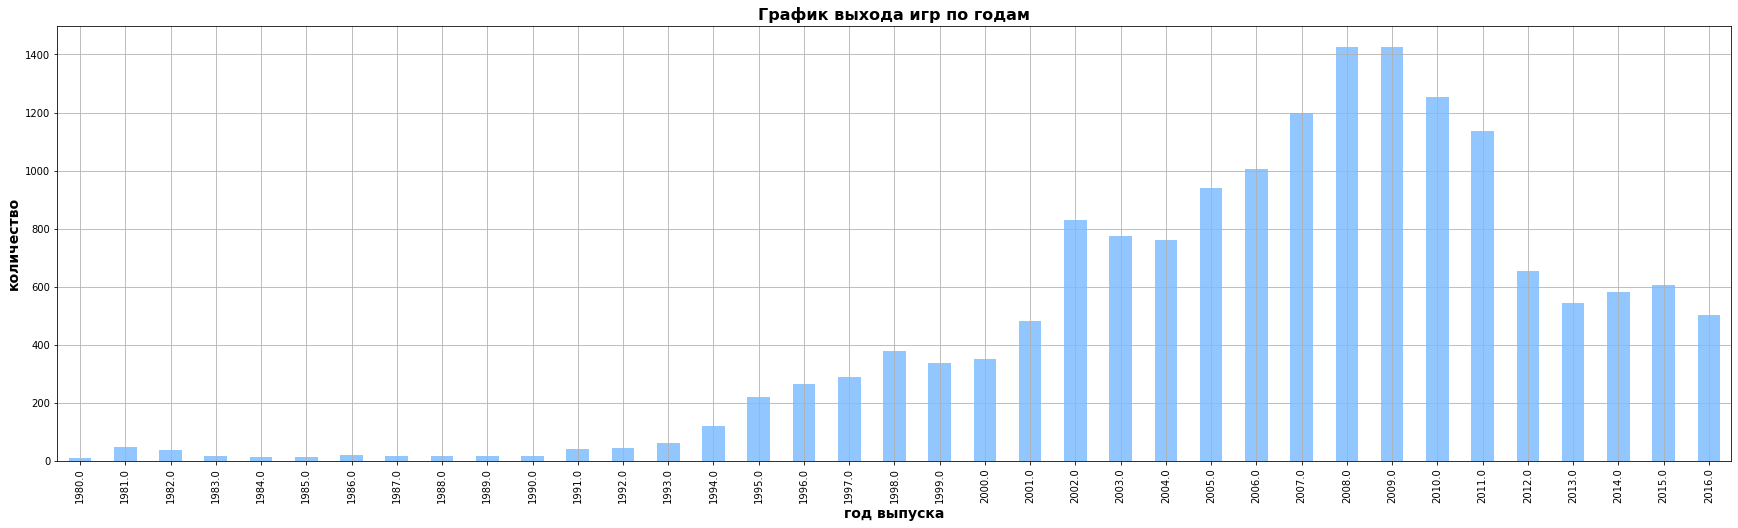

In [16]:
plt.title('График выхода игр по годам', fontweight="bold", color='k', fontsize=16)
plt.style.use('seaborn-pastel')
games.groupby('year_of_release')['platform'].count().plot(grid=True, kind= 'bar', figsize=(30, 8))
plt.xlabel("год выпуска", fontsize=14, fontweight="bold")
plt.ylabel("количество", fontsize=14, fontweight="bold")

Как ПК так и консоли существовали давно, видим на графике год 1980. Тогда технологии были заточены прямо под работу в текстовых редакторах и кодовых программах (про компьютер) либо было недостаточно мощностей (у консоли). Видим скачок с 1994 года и планомерный рост, что наглядно демонстрирует зависимость технологий (графика и мощности), отсюда и выпуск игр, более сложных и интересных. Все мы кстати помним, что легендарная первая PS и Nintendo64 вышли примерно в это время. После 2012 продажи идут на спад. Разберёмся почему так. Казалось в детстве, много игр не бывает.

Проверим эту теорию:

Text(0, 0.5, 'количество')

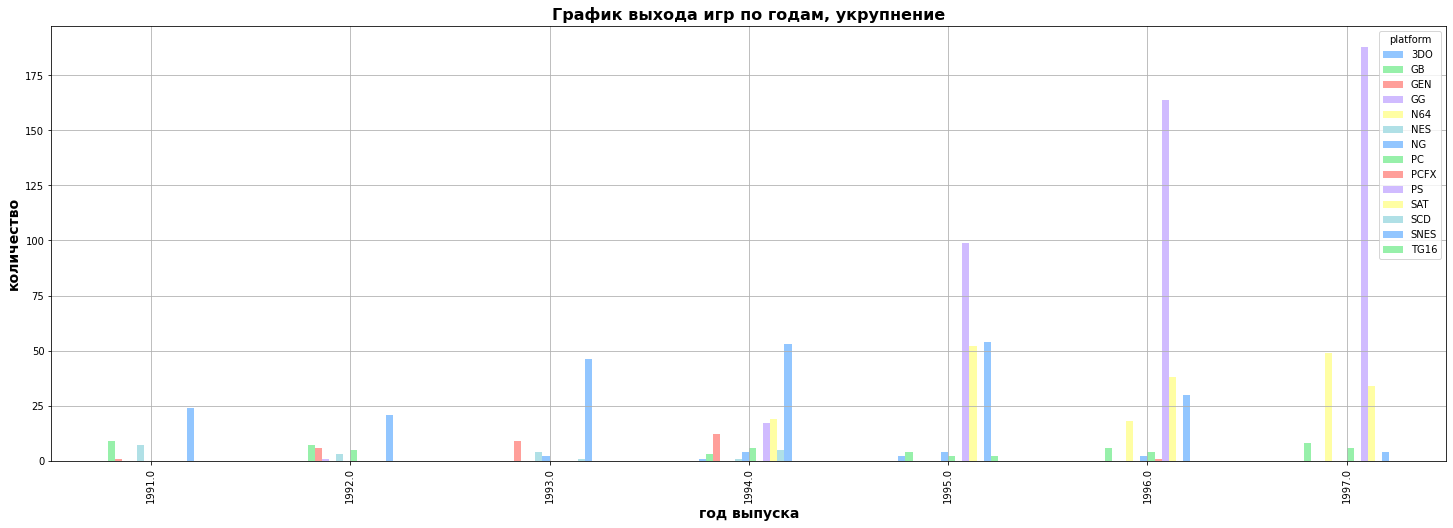

In [17]:

games.query('1998 >year_of_release > 1990').pivot_table(index='year_of_release', columns='platform', values='sales_total', aggfunc='count').plot(grid=True, kind= 'bar', figsize=(25, 8))
plt.title('График выхода игр по годам, укрупнение', fontweight="bold", color='k', fontsize=16)
plt.xlabel("год выпуска", fontsize=14, fontweight="bold")
plt.ylabel("количество", fontsize=14, fontweight="bold")

Что и требовалось доказать :) Плойка и Нинтендо как пионеры – всегда на передовой! И не стоит забывать о старичках, как 3DO – пик продаж игр для неё пришёлся как раз на это время. А мы идём дальше.

<br/><a name="3.2."></a>
<b>3.2. Количество выпущенных игр по платформам</b>.<br/>
<font size="2">([к содержанию](#0.0))</font>

Посмотрим на количество игр в разрезе по платформам:

Text(0, 0.5, 'Игровые платформы')

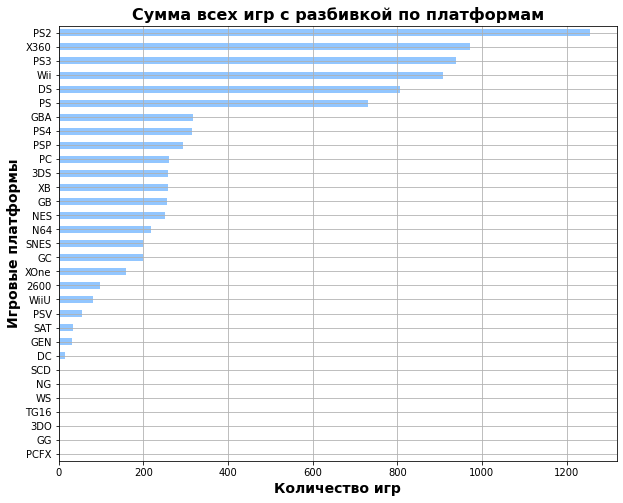

In [18]:
plt.title('Сумма всех игр с разбивкой по платформам', fontweight="bold", color='k', fontsize=16)
plt.style.use('seaborn-pastel')
games.groupby('platform')['sales_total'].sum().sort_values().plot(grid=True, kind= 'barh', figsize=(10, 8))
plt.xlabel("Количество игр", fontsize=14, fontweight="bold")
plt.ylabel("Игровые платформы", fontsize=14, fontweight="bold")

Топ-6 долгожителей и лидеров таков: PS2, X360, PS3, Wii, DS, PS.
Хочется подчеркнуть, что тут заметна взаимосвязь от продаж по годам. Другими словами, платформы, чей расцвет пришёлся на потребительский ажиотаж вокруг игровой индустрии (2001 - 2011) сумели удержаться в топе, не смотря на то, что к 2016 году уже не актуальны. И наоборот, платформы, которые по сути нового поколения (продажи игр для PS3 в отличие от PS2) уже не успели к буму и собирают тот спрос, который остался на исходе, снижающийся.  

<br/><a name="3.3."></a>
<b>3.3. Динамика продаж игр по платформам</b>.<br/>
<font size="2">([к содержанию](#0.0))</font>

Узнаем, как менялись продажи по платформам на заданном отрезке. Выделим топ игровых платформ. Попробуем узнать срок жизни платформы и проследим динамику их развития в прошлом и чуть поближе.

<br/><a name="3.3.1."></a>
<b>3.3.1. График динамики продаж по годам по каждой платформе.</b></br><br/>
<font size="2">([к содержанию](#0.0))</font>

In [19]:
import plotly.express as px
fig = px.line(games.pivot_table(index = ['year_of_release', 'platform'], values = 'sales_total', aggfunc = 'sum').reset_index(),
             x = 'year_of_release', y = 'sales_total', color = 'platform', title='Динамика продаж по годам'
)

fig.show()

Посмотрим на топ платформ по продажам:

In [20]:
games.groupby('platform')['sales_total'].sum().to_frame('sales_total').sort_values(by='sales_total', ascending=False).head(10)

,sales_total
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


<br/><a name="3.3.2."></a>
<b>3.3.2. График динамики продаж по годам по топ-6 платформ:</b></br><br/>
<font size="2">([к содержанию](#0.0))</font>

In [21]:
fig = px.line(games.query('platform == "PS2" or platform == "X360" or platform == "PS3" or platform == "Wii" or platform == "DS" or platform == "PS"').pivot_table(index = ['year_of_release', 'platform'], values = 'sales_total', aggfunc = 'sum').reset_index(),
             x = 'year_of_release', y = 'sales_total', color = 'platform', title='Динамика продаж по годам топ-6 платформ')
fig.show()

Вывод:<br/>
В целом продолжительность жизни игровой платформы колеблется от 5 до 25 лет. Медианая продолжительность для топовых консолей около 10 лет. Можно отметить как с ростом игровых запросов и прогресса количество платформ увеличивалось а их жизненный цикл уменьшался, хотя есть и долгожители, продажи от игр которых принесли разработчикам приличные деньги, например DS (вы только гляньте).

Годы жизни для топа:
* PS - с 1994 года до 2003;
* PS2 - с 2000 до 2011 года;
* PS3 - с 2006 по сей день;
* DS - вышла в 1985, затем затишье, как будто пользовалась популярность вне нашего датасета, а с 2004 уже виден взрыв статистики и по сей день живёт;
* Wii - с 2006 по сей день.
* Wii - с 2006 по сей день.

Как и отметили ранее, медиана по топу установилась где-то на 10-ке. 

<br/><a name="3.4."></a>
<b>3.4. Динамика продаж игр в наше время</b>.<br/>
<font size="2">([к содержанию](#0.0))</font>

Чтобы построить предсказательные модели на 2017 год корректно, выберем актуальный период, за который посмотрим данные по платформам.<br/><br/>
Выберем период с 2012 по 2016 год. Потому что:<br/>
* после 2012 года произошла стабилизация рынка после взлёта продаж и на отрезке остались наиболее актуальные платформы;
* в это год, когда вышли или вот-вот выйдут все популярные консоли если смотреть из новинок;
* в этом периоде представлены данные по абсолютно всем самым популярным консолям.

Остальной период нас не будет беспокоить в дальнейшем.

Посмотрим на динамику продаж по актуальным годам и ответим на вопрос:<br/>
Какие платформы лидируют по продажам, растут или падают?<br/><br/>
Далее выберем самые богатые и потенциальные платформы.

In [22]:
fig = px.line(games.query('year_of_release >= 2012').pivot_table(index = ['year_of_release', 'platform'], values = 'sales_total', aggfunc = 'sum').reset_index(),
             x = 'year_of_release', y = 'sales_total', color = 'platform', title='Динамика продаж прибыльных платформ')
fig.show()

На конец 2016 года лидируют по продажам следующие платформы:
* <b>PS4</b>;
* <b>Xone</b>;
* <b>PS3</b>;
* <b>3DS</b>;
* <b>WiiU</b>.

Это топ-5. Видно, что конкуренция и гонка технологий большая, отсюда резкие сокращения дистанций по продажам во времени между новым поколением консолей и старичками. Причем, исходя из данных, количество продаж игр, выпущенных на каждую из прибыльных платформ, снижается. Таким образом, можно сказать, что весь рынок игр падает.

Стоит отметить динамику продаж игр на PC, которая тоже начала снижаться после 2013 года. Ранее на графиках мы видели, что продажи пусть и небольшие но аудитория стабильно платит за продукт. Не стоит забывать и о пиратстве, которое обделяет разработчиков и не стимулирует рост качества в играх. Нельзя с уверенностью сказать, что с появлением мобильных игр (если можно провести аналогию с телефоном, который тоже изначально не был предназначен для игр), продажи будут расти. Если только платформа вступит в симбиоз с VR играми и предложит уникальное развлечение. Потенциал в этом есть, посмотрим, что будет дальше :)

<br/><a name="3.5."></a>
<b>3.5. Boxplot по глобальным продажам игр и с разбивкой по платформам</b>.<br/>
<font size="2">([к содержанию](#0.0))</font>

Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Опишем результат.

<br/><a name="3.5.1."></a>
<b>3.5.1. Boxplot по глобальным продажам игр</b>.<br/>
<font size="2">([к содержанию](#0.0))</font>

Text(0.5, 0, 'Продажи')

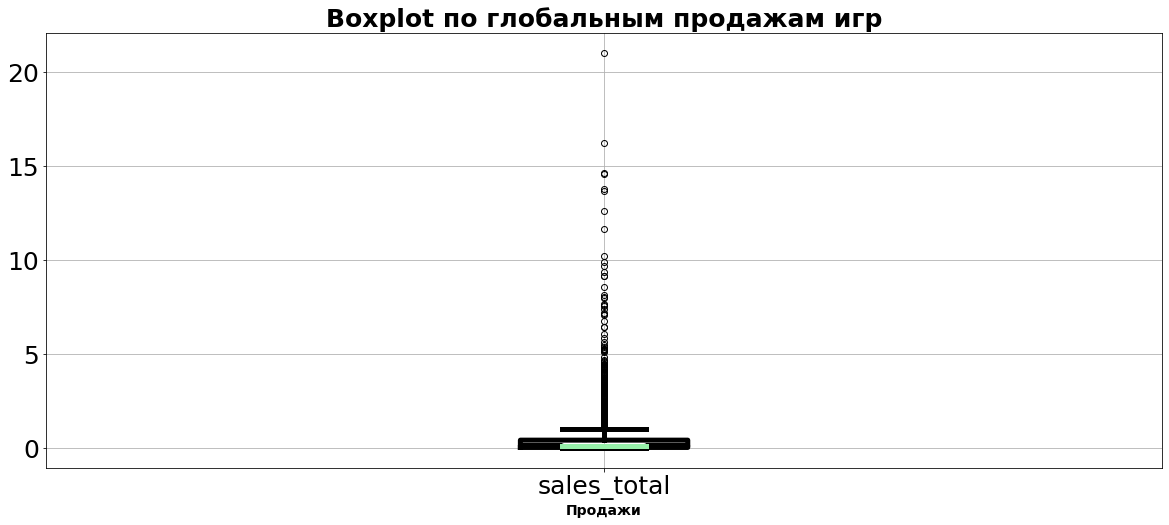

In [23]:
games_new = games.query('year_of_release >= 2012').copy()
games_new.boxplot(column='sales_total', fontsize=25, figsize=(20,8),
                                         boxprops=dict(linestyle='-', linewidth=5),
                                         medianprops=dict(linestyle='-', linewidth=5),
                                         whiskerprops=dict(linestyle='-', linewidth=5),
                                         capprops=dict(linestyle='-', linewidth=5), 
                                         notch=True).set_title('Boxplot по глобальным продажам игр', fontsize=25, fontweight='bold')
plt.xlabel("Продажи", fontsize=14, fontweight="bold")

Посмотрим ближе:

Text(0.5, 1.0, 'Boxplot по глобальным продажам игр')

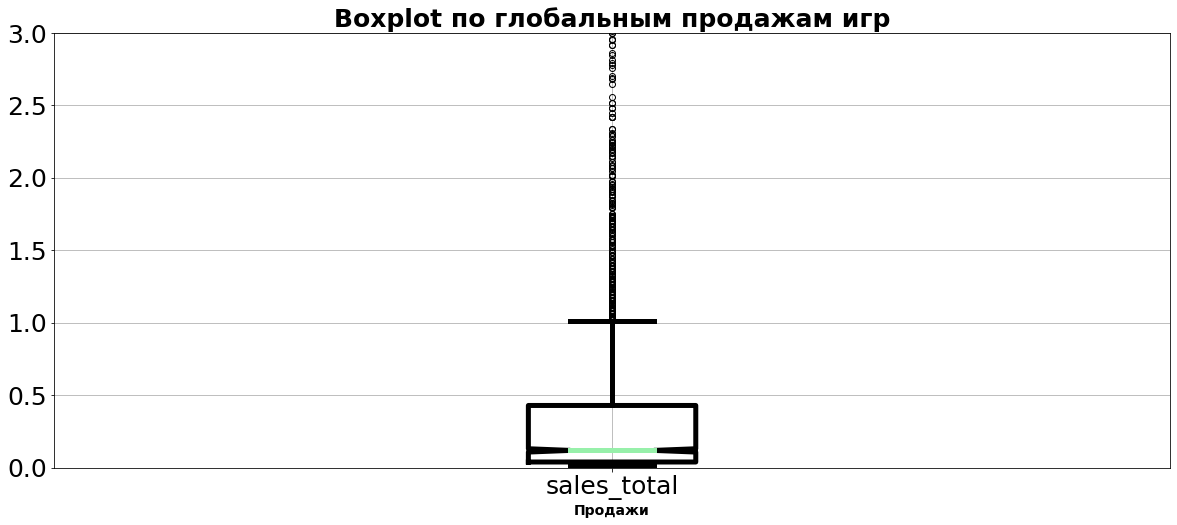

In [24]:
games_new.boxplot(column='sales_total', fontsize=25, figsize=(20,8),
                                         boxprops=dict(linestyle='-', linewidth=5),
                                         medianprops=dict(linestyle='-', linewidth=5),
                                         whiskerprops=dict(linestyle='-', linewidth=5),
                                         capprops=dict(linestyle='-', linewidth=5), 
                                         notch=True).set_ylim([0,3])
plt.xlabel("Продажи", fontsize=14, fontweight="bold")
plt.title('Boxplot по глобальным продажам игр', fontsize=25, fontweight='bold') 

В среднем, продажи игр составляют до 1 млн долларов. Медиана - 0,2 миллиона долларов. Не сказать, что это много.

<br/><a name="3.5.2."></a>
<b>3.5.2. Boxplot по самым кассовым платформам нашего времени</b>.<br/>
<font size="2">([к содержанию](#0.0))</font>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Text(0.5, 0, 'Платформы')

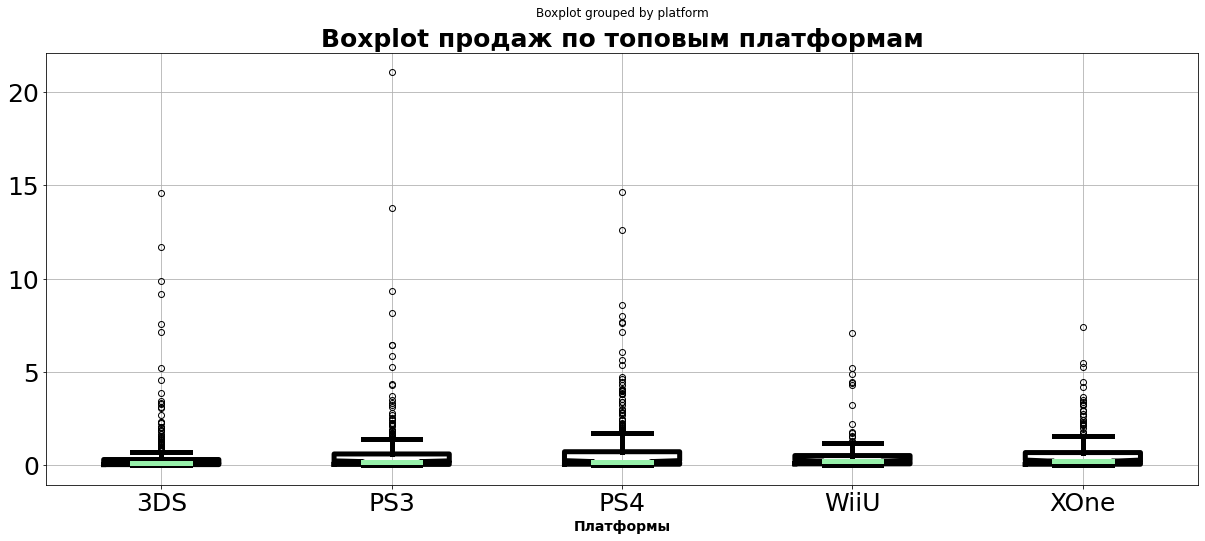

In [25]:
top_platforms = games_new.query('platform == "PS4" or platform == "XOne" or platform == "PS3" or platform == "WiiU" or platform == "3DS"')
top_platforms.boxplot('sales_total', by='platform', fontsize=25, figsize=(20,8),                                         
                                         boxprops=dict(linestyle='-', linewidth=5),
                                         medianprops=dict(linestyle='-', linewidth=5),
                                         whiskerprops=dict(linestyle='-', linewidth=5),
                                         capprops=dict(linestyle='-', linewidth=5), 
                                         notch=True)
plt.title('Boxplot продаж по топовым платформам', fontsize=25, fontweight='bold') 
plt.xlabel("Платформы", fontsize=14, fontweight="bold")

Посмотрим ближе:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Text(0.5, 0, 'Платформы')

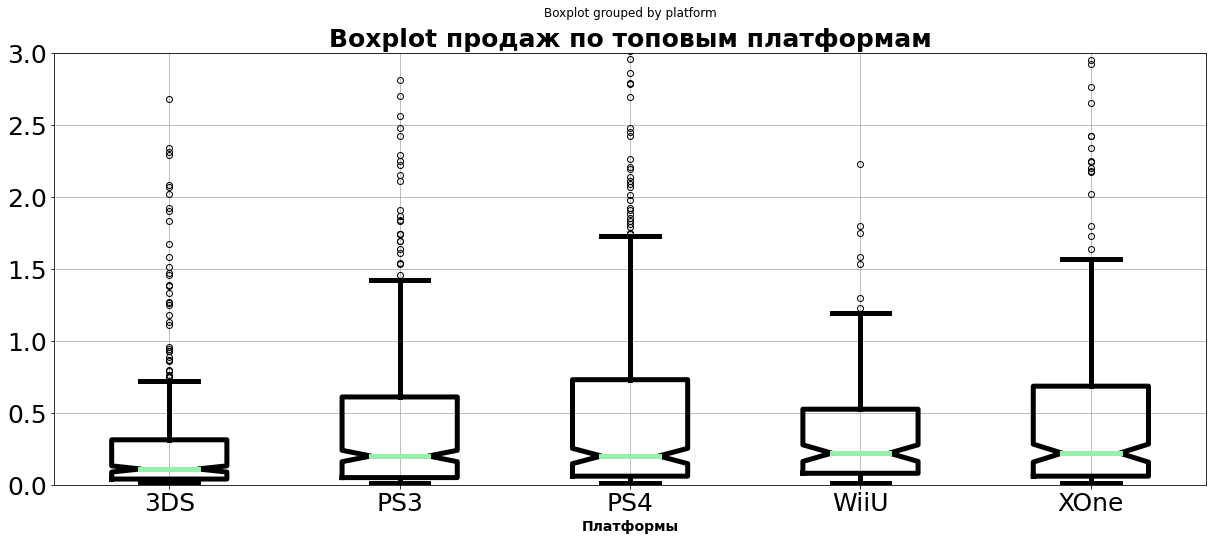

In [26]:
top_platforms.boxplot('sales_total', by='platform', fontsize=25, figsize=(20,8),                                         
                                         boxprops=dict(linestyle='-', linewidth=5),
                                         medianprops=dict(linestyle='-', linewidth=5),
                                         whiskerprops=dict(linestyle='-', linewidth=5),
                                         capprops=dict(linestyle='-', linewidth=5), 
                                         notch=True).set_ylim([0,3])
plt.title('Boxplot продаж по топовым платформам', fontsize=25, fontweight='bold') 
plt.xlabel("Платформы", fontsize=14, fontweight="bold")

(0.0, 4.0)

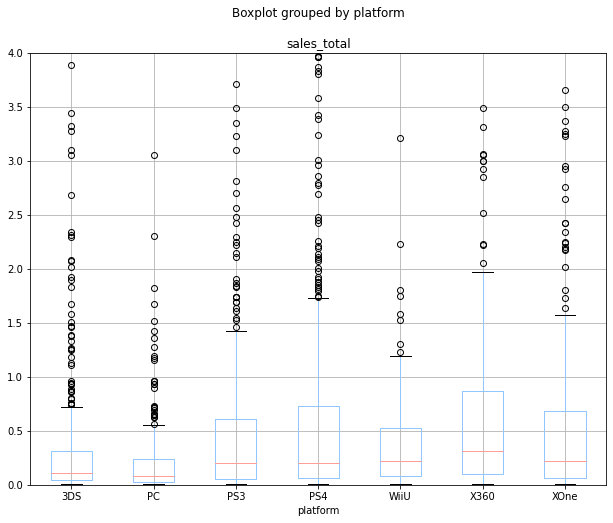

In [27]:
# КОД РЕВЬЮЕРА
import warnings
warnings.filterwarnings('ignore') # Игнорирую предупреждения.

top7_actual = list(games_new.groupby('platform')['sales_total'].sum().to_frame('sales_total').sort_values(by='sales_total', ascending=False).head(7).index)

games_new.query('platform in @top7_actual').boxplot(by='platform', column='sales_total', figsize=(10,8))
plt.ylim(0,4)

Выделяются как наиболее прибыльные: PS4 и XOne; так и совсем ещё маленькие, как 3DS с медианой около 0,2 млн долларов. 
Верхняя граница предела, за которыми уже определяются аномалии, у PS3 - на уровне 1,4 млн долларов; 3DS - 0,7 млн долларов; PS4 - 1,7 млн долларов; WiiU - 1,2 млн долларов; XOne - 1,55 млн долларов;<br/>
У остальных - от 1 до 1,5 миллионов долларов.<br/>
Медиана по топовым платформам варьируется от 0,2 до 0,25 млн долларов прибыли за игру.<br/>



<br/><a name="3.6."></a>
<b>3.6. Влияние отзывов пользователей и критиков на продажи</b>.<br/>
<font size="2">([к содержанию](#0.0))</font>

За образец возьмем самую топовую  платформу  - PS4. Конечно, она не так давно на рынке, однако, на конец 2016 года она является одной из самых популярных игровых платформ.

In [28]:
games_ps4 = games[(games['platform'] == 'PS4') & (games['critic_score'] > 0)].copy()

<br/><a name="3.6.1."></a>
<b>3.6.1. Диаграмма рассеяния зависимости общей суммы продаж игры от отзывов критиков</b>:<br/>
<font size="2">([к содержанию](#0.0))</font>

Text(0, 0.5, 'Продажи')

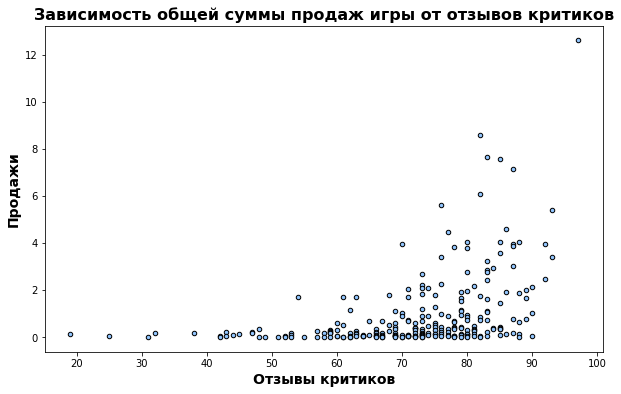

In [29]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger

games_ps4 = games_new[(games_new['platform'] == 'PS4') & (games_new['critic_score'] > 0)].copy()
games_ps4.plot(kind='scatter', x='critic_score', y='sales_total', ec='black', figsize=(10,6))
plt.title('Зависимость общей суммы продаж игры от отзывов критиков', fontweight="bold", color='k', fontsize=16)
plt.xlabel("Отзывы критиков", fontsize=14, fontweight="bold")
plt.ylabel("Продажи", fontsize=14, fontweight="bold")

С увеличением среднего рейтинга критиков увеличивается и средний уровень выручки с продажи игр, что логично: чем качественнее игра, тем больше денег она приносит разработчику и издателю.

Теперь от отзывов пользователей:

Text(0, 0.5, 'Продажи')

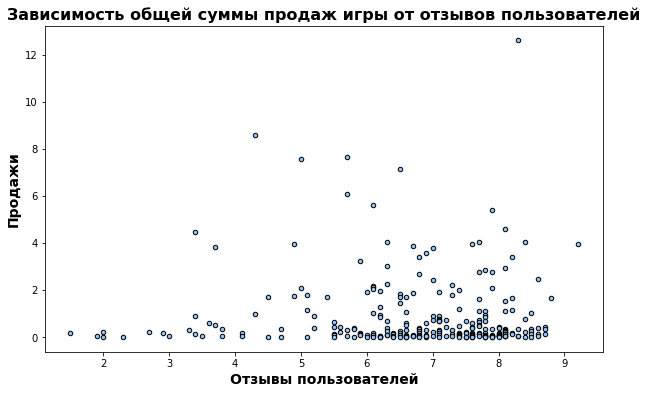

In [30]:
games_ps4 = games_new[(games_new['platform'] == 'PS4') & (games_new['user_score'] > 0)].copy()
games_ps4.plot(kind='scatter', x='user_score', y='sales_total', ec='black', figsize=(10,6))
plt.title('Зависимость общей суммы продаж игры от отзывов пользователей', fontweight="bold", color='k', fontsize=16)
plt.xlabel("Отзывы пользователей", fontsize=14, fontweight="bold")
plt.ylabel("Продажи", fontsize=14, fontweight="bold")

Видна обратная зависимость – рейтинг пользователей не велик, но тем не менее игра собирает большие деньги. Такое случается с игроками, когда сработал маркетинг и реклама. Игроки на энтузиазме покупают игру, ожидания слишком высоки и так легче расстроится и принести разработчикам прибыль, а затем поставить игре плохую оченку.

<br/><a name="3.6.2."></a>
<b>3.6.2. Матрица корреляции</b>:<br/>
<font size="2">([к содержанию](#0.0))</font>

Text(0.5, 1.0, 'Матрица корреляции')

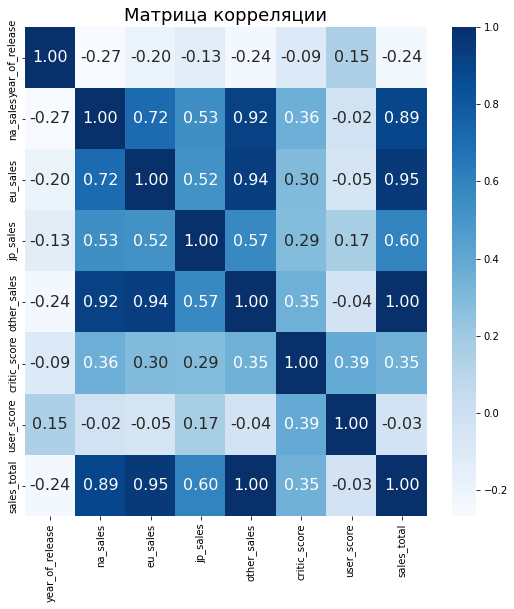

In [31]:
plt.figure(figsize=(9,9))
sns.heatmap(games_ps4.corr(), annot=True, cmap="Blues", fmt='.2f', annot_kws={'size':16})
plt.title("Матрица корреляции", fontsize = 18)


Выделим нужные нам данные:

In [32]:
games_ps4_filtered = games_ps4[['sales_total' ,'critic_score', 'user_score']]

Text(0.5, 1.0, 'Корреляция продаж')

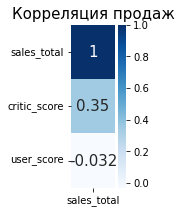

In [33]:
plt.figure(figsize=(1,3))
sns.heatmap(games_ps4_filtered.corr()[['sales_total']].sort_values(by='sales_total', ascending=False), cmap="Blues", 
            annot=True, annot_kws={'size':15})
plt.title("Корреляция продаж", fontsize = 15)

Сильнее всего на конечную стоимость влияет оценка критиков. В обратном порядке влияет - оценка пользователей.

<br/><a name="3.6.3."></a>
<b>3.6.3. Данные по корреляции по топовым платформам:</b><br/>
<font size="2">([к содержанию](#0.0))</font>

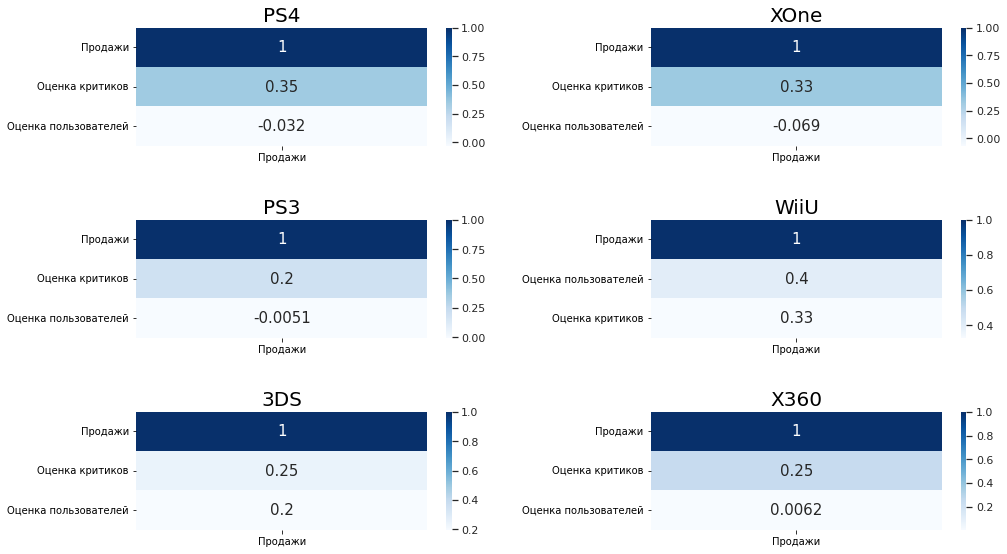

In [34]:
top_platforms = ['PS4', 'XOne', 'PS3', 'WiiU', '3DS', 'X360']

rows = len(top_platforms) // 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(15,8.5))
count = 0
for r in range(rows):
    for c in range(cols):
        curr_platform = top_platforms[count]
        df_prep = games_new[(games_new['platform'] == curr_platform) & (games_new['user_score'] > 0)].copy()
        df_filtered = df_prep[['sales_total' ,'critic_score', 'user_score']].rename({'sales_total': 'Продажи', 'critic_score': 'Оценка критиков', 'user_score': 'Оценка пользователей'}, axis=1)
        sns.set(font_scale=1.0)
        ax = sns.heatmap(df_filtered.corr()[['Продажи']].sort_values(by='Продажи', ascending=False), 
                         cmap="Blues", annot=True, annot_kws={'size':15}, ax=axes[r,c])
        ax.set_title(curr_platform, fontsize=20)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        plt.tight_layout(pad=3)
        count += 1
 

В корреляции по отзывам критиков более менее совпадают с общей у платформ <b>PS4, XOne</b> и <b>WiiU</b>. Меньше всего у **3DS**, **X360** и **PS3**.<br/>

В корреляции по отзывам пользователей выделяются <b>3DS</b> и <b>WiiU</b> у которой корреляция самая большая, видимо сказывается уровень экспертной оценки азиатских игроков, что "определяет" конечную выручку продукта сильнее, чем оценка критиков. Остальные платформы имеют либо незначительную зависимость, либо вовсе отрицательную.

<br/><a name="3.7."></a>
<b>3.7. Распределение игр по жанрам</b>.<br/>
<font size="2">([к содержанию](#0.0))</font>

Нарисуем столбчатую диаграмму с количеством и общей суммой продаж и расскажем о самых прибыльных жанрах, а потом посмотрим на особенности жанров с высокими и низкими продажами.

In [35]:
import plotly.graph_objects as go
pivot = games_new.groupby('genre').agg({'name': 'count', 'sales_total': 'sum'}).sort_values(by='name', ascending=True)
list_genres = games_new.groupby('genre').agg({'name': 'count', 'sales_total': 'sum'}).sort_values(by='name', ascending=True).index.tolist()

fig = go.Figure()
fig.add_trace(go.Bar(x=list_genres,
                y=pivot['name'],
                name='Количество продаж',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=list_genres,
                y=pivot['sales_total'],
                name='Общая сумма продаж',
                marker_color='rgb(26, 118, 255)'
                ))

fig.update_layout(
    title='Распределение продаж по жанрам',
    xaxis_tickfont_size=20,
    yaxis=dict(
        title='Продажи',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1 
)
fig.show()

Больше всего игр жанра <b>Action</b>. За ними идут ролевые игры. Причем даже учитывая то, что ролевой жанр заметно меньше на рынке (на треть от <b>Action</b>). Далее странный мув от приключенческого жанра и его дисбаланс по прибыли, кажется кто-то сильно дёшево стоит, чего не скажешь о шутерах, которые стараются компенсировать изо всех сил пиратство (так как Шутеры преимущественно выходят на PC).


Опишем отдельно топ по количеству проданных копий и продажам.<br/><br/>

<b>Количество проданных копий:</b>
1. <b>Action</b>
2. <b>Ролевые игры</b>
3. **Приключения**
4. **Спортивные**
5. **Шутеры**


...<b>аутсайдеры</b> - игры, которые требуют усидчивости:<br/><br/>
1. **Паззлы**
2. **Стратегии**
3. **Симуляторы**
4. **Платформеные**
5. **Файтинги**

<b>Продажи:</b>
1. <b>Action</b>
2. <b>Шутеры</b>
3. <b>Ролевые</b>
4. **Спортивные**
5. **Аркады**

...<b>аутсайдеры</b>:<br/>
1. **Пазлы**<br/>
2. **Стратегии**<br/>
3. **Приключения**

Рассмотрим детальнее продажи в разрезе жанров по медиане и среднему значению. Чтобы приблизится к пониманию: игры в каких жанрах дороже и кто вытягивает продажи за счёт проданных копий.

In [36]:
pivot3 = games_new.groupby('genre').agg({'sales_total': 'mean'}).sort_values(by='sales_total', ascending=True)
pivot2 = games_new.groupby('genre').agg({'sales_total': 'median'}).sort_values(by='sales_total', ascending=True)
list_genres3 = games_new.groupby('genre').agg({'sales_total': 'mean'}).sort_values(by='sales_total', ascending=True).index.tolist()
list_genres2 = games_new.groupby('genre').agg({'sales_total': 'median'}).sort_values(by='sales_total', ascending=True).index.tolist()

fig2 = go.Figure()
fig2.add_trace(go.Bar(x=list_genres2,
                y=pivot2['sales_total'],
                name='Медианный показатель продаж',
                marker_color='rgb(70, 187, 200)'
                ))
fig2.add_trace(go.Bar(x=list_genres3,
                y=pivot3['sales_total'],
                name='Средний показатель продаж',
                marker_color='rgb(200, 30, 50)'
                ))
fig2.update_layout(
    title='Статистика продаж по жанрам',
    xaxis_tickfont_size=20,
    yaxis=dict(
        title='Продажи',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1 
)
fig2.show()

**Топ показателей продаж:**
1. Шутеры: средняя - 1.3 млн, медианна - 0.44 млн; 
2. Спортивные: средняя - 0.67 млн, медианна - 0.24 млн;
3. Платформеры: средняя - 0.71 млн, медианна - 0.21 млн;
4. Ролевые: средняя - 0.52 млн, медианна - 0.14 млн;
5. Гонки: средняя - 0.46 млн, медианна - 0.14 млн.

Учитывая общий показатель продаж и количество проданных копий на прошлом графике - характеристика жанров с точки зрения производства, маркетинга  открывается любопытная:

- В целом индустрия стремится породить бэстселлеры, ведь только он принесёт много денег. Отсюда и такой большой разброс по всем жанрам в сравнении медианы и среднего (есть небольшое число игры, собирающих большую долю продаж);
- Шутеры как жанр лидируют с точки зрения количества выпущенных игр и продаж, так как статистика по среднему и медиане выше, а общая сумма продаж единственная из всех жанров, обгоняет число проданных игр. То есть как ни крути, заниматься разработкой в этом жанре и производить шутаны – выгодно, даже если пиратство где-то рядом, можно позволить дополнительный отдел по защите от взлома :)
- Аномалия у жанра Экшен. Учитывая медиану и статистику на прошлом графике, тут нужно открывать конвеерный завод, чтобы выйти в плюс (ах, если бы можно было посмотреть на экономику глубже и был бы столбец с затратами на производство каждой игры...). Проданных игр больше, чем у всех остальных, продажи небольшие, отсюда и медианное значение низкое. И среднее не блещет, хотя разница с медианной такая же, как и у всех, значит ещё остались тягачи (Ассасин, ГТА, Бэтмен - приветы), но это капля в море, по сравнению с множеством посредственных игр этого жанра, которые, вероятно, еле выходят в ноль.
- Странная ситуация с приключениями, вероятно они не так дороги в разработке отсюда и цена может быть низкой, что позволяет выпускать приличное число игр но довольствоваться в среднем небольшими (а в случае с медианой - мизерными) продажами. 


В остальном по разнице среднего и медианы видно, что у всех жанров есть передовые игры, которые забирают большую долю продаж а остальная часть довольствуется на порядок меньшей долей.


<hr style="border: 1px solid #000;">

<br/><a name="4."></a>
## Шаг 4. Портрет пользователя регионов NA, EU, JP
<font size="2">([к содержанию](#0.0))</font>

Определим для пользователя каждого региона (NA, EU, JP):
* самые популярные платформы (топ-5), опишем различия в долях продаж;
* самые популярные жанры (топ-5), поясним разницу;
* определим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

<br/><a name="4.2."></a>
<b>4.2. Определение самых популярных платформ в заданных регионах:</b>.<br/>
<font size="2">([к содержанию](#0.0))</font>

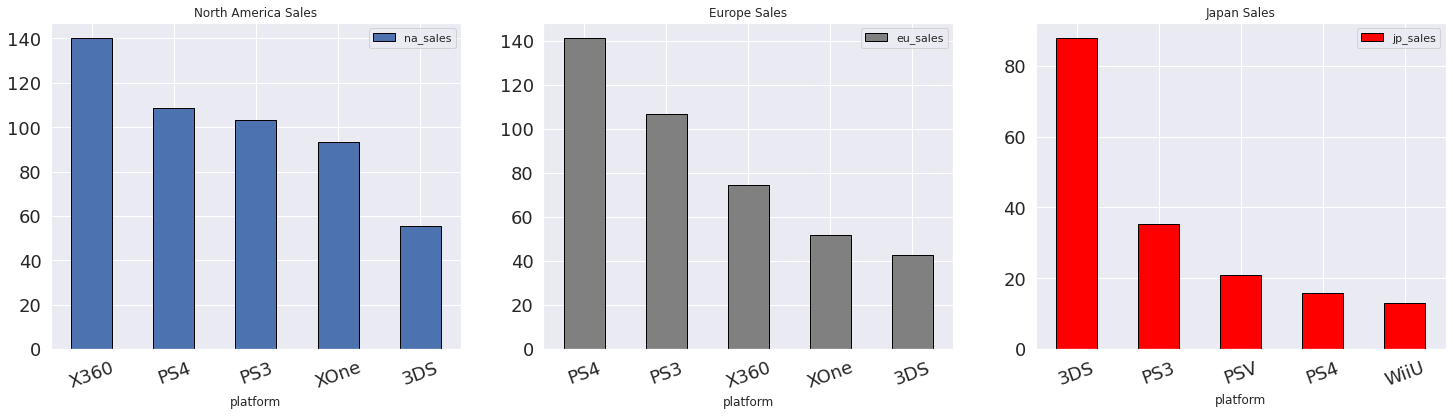

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))
games_new.pivot_table(
               index=["platform"],
               values=["na_sales"], aggfunc=np.sum).sort_values(by=["na_sales"], ascending=False)[:5].plot(kind='bar', ec='black', title='North America Sales', 
                   fontsize=18, color=None, rot=20, ax=axes[0])
games_new.pivot_table(
               index=["platform"],
               values=['eu_sales'], aggfunc=np.sum).sort_values(by=['eu_sales'], ascending=False)[:5].plot(kind='bar', ec='black', title='Europe Sales', 
                   fontsize=18, color='grey', rot=20, ax=axes[1])
games_new.pivot_table(
               index=["platform"],
               values=['jp_sales'], aggfunc=np.sum).sort_values(by=['jp_sales'], ascending=False)[:5].plot(kind='bar', ec='black', title='Japan Sales',
                   fontsize=18, color='red', rot=20, ax=axes[2])        
fig.show()                 

В <b>Северной Америке</b> имеют бешеную популярность на равне с приставкой прошлого поколения <b>X360</b> ещё и новички <b>PS4</b>. Далее в обратной последовательности старичок-новичок <b>PS3</b> и <b>XOne</b>. Не набрала ещё большой популярности <b>3DS</b>.

В <b>Европе</b> очевидным лидером являются платформы **PS**. **Иксбоксы** не на столько пользуются спросом, как и малыш **3DS** <br/>

В <b>Японии</b>, как обычно, всё наоборот. Лидер - <b>3DS</b>. За ними американские **PS3**, **PSV** и **PS4**. Далее японская **WiiU**.

<br/><a name="4.3."></a>
<b>4.3. Определение самых популярных жанров в заданных регионах:</b><br/>
<font size="2">([к содержанию](#0.0))</font>

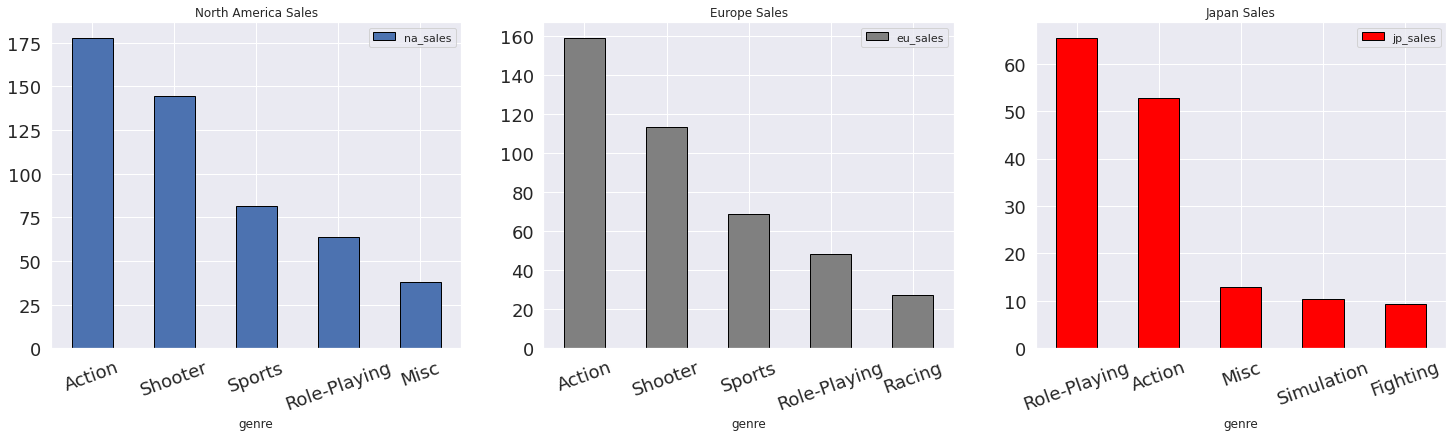

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

games_new.pivot_table(
               index=["genre"],
               values=["na_sales"], aggfunc=np.sum).sort_values(by=["na_sales"], ascending=False)[:5].plot(kind='bar', ec='black', title='North America Sales', 
                   fontsize=18, color=None, rot=20, ax=axes[0])
games_new.pivot_table(
               index=["genre"],
               values=['eu_sales'], aggfunc=np.sum).sort_values(by=['eu_sales'], ascending=False)[:5].plot(kind='bar', ec='black', title='Europe Sales', 
                   fontsize=18, color='grey', rot=20,ax=axes[1])
games_new.pivot_table(
               index=["genre"],
               values=['jp_sales'], aggfunc=np.sum).sort_values(by=['jp_sales'], ascending=False)[:5].plot(kind='bar', ec='black', title='Japan Sales',
                   fontsize=18, color='red', rot=20, ax=axes[2])   
fig.show()

В <b>Северной Америке</b> и <b>Европе</b> вкусы практически не отличимы: и там, и там играют в жанре <b>экшнов</b>, <b>шутеров</b>, <b>спортивных</b> и <b>ролевых</b> игр. В <b> Северной Америке</b> больше играют в <b>аркады</b>, в Европе же чаще выбирают <b>гонки</b>.<br/><br/>

В <b>Японии</b> вкус отличается - на первом месте <b>ролевые игры</b> и <b>экшны</b> с небольшим отставанием. Далее <b>аркадные</b>, <b>симуляторы</b> и <b>файтинги</b>.

<br/><a name="4.4."></a>
<b>4.4. Влияние рейтинга ESRB на продажи в отдельном регионе</b>.<br/>
<font size="2">([к содержанию](#0.0))</font>

Добавим новый столбец в основной датафрейм с разъяснением, какая буква рейтинга что означает:

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid">
<и> Комментарий ревьюера 3</и>
    
Здесь необходимо рассмотреть также и отсутствующий возрастной рейтинг, предварительно заменив его на маркерное значение. Эта задача является отличным примером того, что даже пропущенные значения могут нести в себе важную информацию. 
</div>

In [39]:
ESRB_dict = {'E': 'Для всех', 'M': '> 17 лет', 'T': '13-19 лет', 'E10+': '>10 лет', 'No_ESRB': 'Вне рейтинга', 'K-A': 'Для всех(устар.)'}

In [40]:
games_new['ESRB_description'] = games_new[games_new['rating'].notnull()]['rating'].map(ESRB_dict)

Посмотрим на продажи игр по рейтингу:

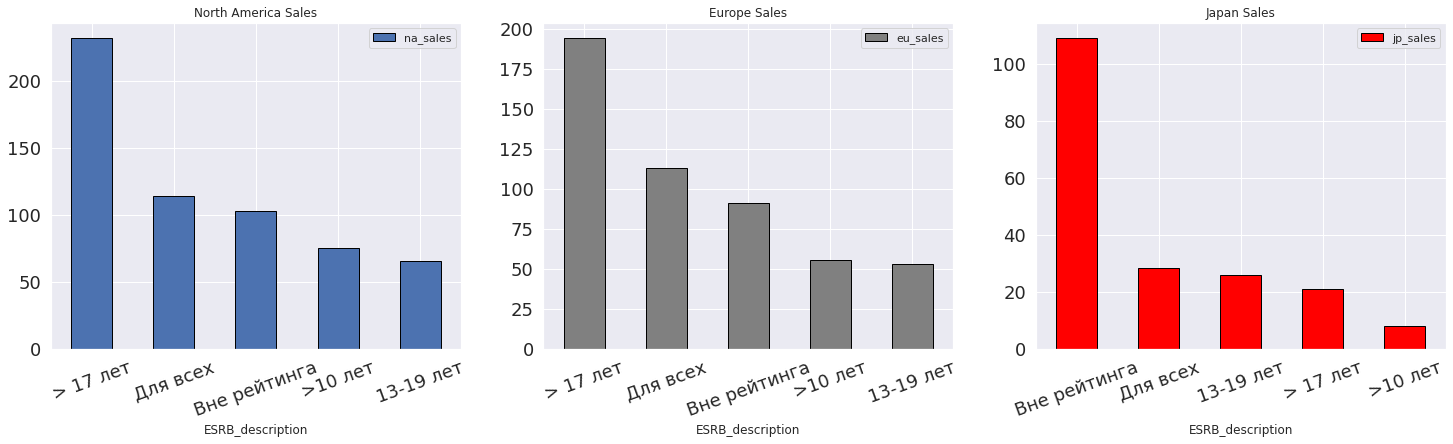

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

games_new.pivot_table(
               index=["ESRB_description"],
               values=["na_sales"], aggfunc=np.sum).sort_values(by=["na_sales"], ascending=False)[:5].plot(kind='bar', ec='black', title='North America Sales', 
                   fontsize=18, color=None, rot=20, ax=axes[0])
games_new.pivot_table(
               index=["ESRB_description"],
               values=['eu_sales'], aggfunc=np.sum).sort_values(by=['eu_sales'], ascending=False)[:5].plot(kind='bar', ec='black', title='Europe Sales', 
                   fontsize=18, color='grey', rot=20,ax=axes[1])
games_new.pivot_table(
               index=["ESRB_description"],
               values=['jp_sales'], aggfunc=np.sum).sort_values(by=['jp_sales'], ascending=False)[:5].plot(kind='bar', ec='black', title='Japan Sales',
                   fontsize=18, color='red', rot=20, ax=axes[2])   
fig.show()

В <b>Северной Америке</b> и в <b>Европе</b> картина практически одинаковая. Большая часть выручки получено с игр с рейтингом <b>"для лиц старше 17 лет"</b>, далее с рейтингом <b>"Для всех"</b>, <b>"Вне рейтинга"</b>, <b> "для лиц старше 10 лет"</b> и **"старше 13-19 лет"**.<br/><br/>
В <b>Японии</b> опять не так. Первое место - <b>"Вне рейтинга"</b>, далее <b>"Для всех"</b>, а на третьем - пятом месте игры для лиц <b>от 13 до 19 лет</b>, <b>"для лиц старше 17 лет"</b> и <b> "для лиц старше 10 лет"</b>.

Что можно сказать про игры вне рейтинга. Они действительно занимают лидерство в Японии, что подтверждает теорию о необходимости найти локальные рейтинговые агенства и узнать подробнее, отчего нету. Возможно сам институт классификации игр не развит в Японии для отечественного разработчика, также игры без рейтинга в силу своей непопулярности/маленькой аудитории не рассматриваются рейтинговыми агенствами на западе в том числе, так как мы видим, что похожее число продаж по внерейтинговым играм есть и там. Вероятно это одни и те же игры (если смотреть по жанрам, то топ Японии - ролевые игры и экшн, они могли легко проникнуть на запад, ведь там тоже эти жанры в топе и пользуются популярностью).

<hr style="border: 1px solid #000;">

<br/><a name="5."></a>
## Шаг 5. Проверка гипотез
<font size="2">([к содержанию](#0.0))</font>

<font size="3"><b>Гипотезы</b>:</font>
* средние пользовательские рейтинги платформ <b>Xbox One</b> и <b>PC</b> одинаковые;
* средние пользовательские рейтинги жанров <b>Action</b> и <b>Sports</b> разные.

По причине того, что выборки независимы между собой, для проверки гипотез будем использовать <b>t-критерий Стьюдента</b>.

Пороговое значение установим как alpha = 0.05

<br/><a name="5.1."></a>
<b>5.1. Гипотеза № 1</b>:<br/>
<b>средние пользовательские рейтинги платформ Xbox One и PC одинаковые</b>.
<font size="2">([к содержанию](#0.0))</font>

<b>Н0 (нулевая гипотеза)</b> - средние пользовательские рейтинги платформ <b>Xbox One</b> и <b>PC</b> одинаковые.<br/>
<b>Н1 (альтернативная гипотеза)</b> - средние пользовательские рейтинги платформ <b>Xbox One</b> и <b>PC</b> отличаются между собой.

In [42]:
xbox_one_ratings = games_new[(games_new['platform'] == 'XOne') & (games_new['user_score'] > 0)]['user_score']
pc_ratings = games_new[(games_new['platform'] == 'PC') & (games_new['user_score'] > 0)]['user_score']
stat, p = ttest_ind(xbox_one_ratings, pc_ratings)

print('t = {}\np-value = {:.10e}'.format(stat, p))
print('\nПороговое значение alpha = 0.05')

t = 0.5930304646661256
p-value = 5.5350805006e-01

Пороговое значение alpha = 0.05


Не можем отвергнуть нулевую гипотезу.<br/>
Верно следующее утверждение: <b>средние пользовательские рейтинги платформ Xbox One и PC одинаковые.</b><br/><br/>
Посмотрим наглядно:

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid">
<b> Комментарий ревьюера 3</b>
    
А разницу между ними считаем случайной. 
</div>

In [43]:
print('Средняя оценка пользователей игр для платформы Xbox One  - {:.2f}'.format(xbox_one_ratings.mean()))
print('Средняя оценка пользователей игр для платформы PC - {:.2f}'.format(pc_ratings.mean()))

Средняя оценка пользователей игр для платформы Xbox One  - 6.52
Средняя оценка пользователей игр для платформы PC - 6.43


Действительно, хоть Xbox получает в среднем чуть большую оценку по отзывам, тем не менее оченка у PC находится недалеко.

<br/><a name="5.2."></a>
<b>5.2. Гипотеза № 2</b>:<br/>
<b>средние пользовательские рейтинги жанров Action и Sports разные</b>.<br/>
<font size="2">([к содержанию](#0.0))</font>

<b>Н0 (нулевая гипотеза)</b> - средние пользовательские рейтинги жанров <b>Action</b> и <b>Sports</b> одинаковые.<br/>
<b>Н1 (альтернативная гипотеза)</b> - средние пользовательские рейтинги жанров <b>Action</b> и <b>Sports</b> отличаются между собой.

In [44]:
action_ratings = games_new[(games_new['genre'] == 'Action') & (games_new['user_score'] > 0)]['user_score']
sport_ratings = games_new[(games_new['genre'] == 'Sports') & (games_new['user_score'] > 0)]['user_score']
stat, p = ttest_ind(action_ratings, pc_ratings)

print('t = {}\np-value = {:.4f}'.format(stat, p))
print('\nПороговое значение alpha = 0.05')

t = 3.2960799450660034
p-value = 0.0010

Пороговое значение alpha = 0.05


Смело отклоняем нулевую гипотезу.<br/>
Таким образом, верно утверждение, что средние пользовательские рейтинги жанров **Action** и **Sports** отличаются между собой.

In [45]:
print('Средняя оценка пользователей игр для платформы Xbox One  - {:.2f}'.format(action_ratings.mean()))
print('Средняя оценка пользователей игр для платформы PC - {:.2f}'.format(sport_ratings.mean()))

Средняя оценка пользователей игр для платформы Xbox One  - 6.83
Средняя оценка пользователей игр для платформы PC - 5.46


<hr style="border: 1px solid #000;">

<br/><a name="6."></a>
## Шаг 6. Общий вывод
<font size="2">([к содержанию](#0.0))</font>

<b>По проверке гипотез удалось выяснить следующее :</b> 
- средние пользовательские рейтинги жанров Action и Sports отличаются между собой.
- средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

<b>По проведенному анализу:</b> 
- самое сильное влияние на итоговую выручку оказывают, в большинстве случаев, оценки критиков (кроме платформы **WiiU**). Оценки пользователей таким "влиянием" на выручку похвастаться не могут(кроме опять же платформы **WiiU**). Важно найти больше до этого неизвестных источников данных (по отзывам и прибыли) среди азиатского сегмента.

**Были найдены наиболее прибыльные жанры, консоли и найдены пути решения для игр с отсутствующим рейтингом:**
- Жанры: Шутеры, Спортивные, Экшен. По соотношению количества игр к объёмам продаж лидируют шутеры (с приятным лидерством по средней и медиане среди всех жанров), золодая середина у спортивных и берёт количеством игр жанр экшона.
- Консоли: Семейство PS3-PS4, Иксбоксы X360 - XOne, японский тигр - 3DS, который ещё себя покажет. Иксбоксы конечно останутся на уровне, так как концепция Майкрософт целится в массового потребителя и его стандартные запросы. А вот с платформами PS на западе может произойти тоже, что и в Японии - 3DS их обгонит, просто нужно время, это конечно не случится за год.
- По рейтингу: игры для лиц старше 17 лет, Для всех и вне рейтинга. Первое место с рейтингом от 17 лет вероятно занимают бестселлеры, которые тянут за счёт качественного сюжета, естественно с элементами жестокости и насилия, за это мы их и любим, но детям нельзя. Середина у игр для всех – понятно, что чем рейтинг свободнее, тем проще продать игру, ведь её может купить кто угодно. Вне рейтинга – игры около экшона и ролевого жанра, преимущественно японского производства на азиатских платформах, что не так распространено на западе, но есть задел выяснить, почему им не дают рейтинг покопавшись у местных дистрибьюторов и агенств.

<b>В целом про положение дел в игровой индустрии:</b> 

- Отчасти, за счёт перехода к мобильным играм (и настолкам may be) индустрия вступает в кризис (падение продаж у всех платформ), который уже сокращает средние показатели продаж за одну игру, хотя работать в некоторых жанрах (Шутеры) ещё можно. В остальном если ты хочешь конкурировать за свой кусок в продажах, традиционно, займи свою нишу – сокращай затраты на разработку и довольствуйся медианным значением от продаж, либо будь в тренде, адаптируйся и вкладывай в игровые франшизы, работай над концепцией и самый дорогой вариант – проработай игру до мелочей, сделай их не много, но качественно и лучше чем у всех остальных, сколько бы это ни стоило, создай из игры бренд и прислушивайся к своей аудитории. 

- Рынок немного сократится и очиститься от мелких фирм и неконкурентных платформ в будущем, но будет жить дальше, трансформируясь во что-то в симбиозе с другими устройствами и сервисами (мобильные, VR, кластеры онлайн-сервисов).А пока этого не случилось и новых решений нет, будут дальше появляться и исчезать всё новые и новые поколения консолей, цикл которых будет сокращаться (интересно, до какой степени можно ускориться, как айфоны что ли). Выживет тот, кто сможет позволить себе большие проекты и спешлы, что в целом актуально у игроков, с выходом в экосистему (привет, Гейб), либо максимально дешёвые в производстве и на выходе бесплатные игры, которые будут монетизироваться как-то за счёт рекламы и тд.

- Датасет не учитывает объёмы продаж индустрии VR (<a href="https://old.computerra.ru/2004/529/204447/"> 15 млрд. на секундочку уже в 2016 году</a>) и в частности игр из этой области и "шлемов", а так же стриминговых сервисов и другого игрового контента. Рекомендую сравнить их результаты по годам и возможно это и есть перетекание капитала и пользовательского спроса.